## Students Information

1. - **Name**: Eman Ibrahim Elbedwihy 
   - **ID**: `9210265`

2. - **Name**: Sara Gamal Gerges
   - **ID**: `9210455`


In [1]:
import json
from collections import deque
from dataclasses import dataclass
from typing import List
import graphviz
import string
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from tqdm import tqdm

# Visiualizing Graphs

In [2]:


def draw(json_format, output_file):
    dot = graphviz.Digraph(format="png")
    dot.attr(rankdir="LR", nodesep="0.5", ranksep="0.5")


    # Extract the starting state
    start_state = json_format["startingState"]

    ##color the starting state
    dot.node(start_state, shape="circle", style="filled", fillcolor="lightgrey")
    ##add edge to starting state from no where
    dot.node("", shape="point")  # Add an invisible starting point
    dot.edge("", start_state, label="start")


    for state, transitions in json_format.items():
        if state == "startingState":
            continue
        # Mark accepting (terminating) states differently
        if transitions["isTerminatingState"]:
            dot.node(state, shape="doublecircle")
        else:
            dot.node(state, shape="circle")

        if(output_file=="nfa_graph"):
          # Add transitions
          for symbol, target_state in transitions.items():
              if symbol != "isTerminatingState":  # Avoid unnecessary key
                  for target in target_state:
                      dot.edge(state, target, label=symbol)
        else:
          # Add transitions
          for symbol, target_state in transitions.items():
              if symbol != "isTerminatingState":  # Avoid unnecessary key
                      dot.edge(state, target_state, label=symbol)
    # Render and save the graph make width longer

    dot.render(output_file,)
    ##plot  the image 
    img = mpimg.imread(output_file + ".png")

    # Get the original dimensions
    height, width = img.shape[:2]

    # Convert pixels to inches (assuming 100 DPI)
    dpi = 100  
    figsize = (width / dpi, height / dpi)

    # Create a figure with the original size
    plt.figure(figsize=figsize, dpi=dpi)

    plt.imshow(img)
    plt.axis('off')
    plt.title(output_file)
    plt.show()

## NFA

In [73]:
from dataclasses import dataclass
from typing import List
import json
precedence={
    "*": 6,
    "+": 5,
    "?": 4,
    ".": 3,
    "&": 2,
    "|": 1,
    "(": 0,
   }
@dataclass
class State:
    index: int = 0
    def __post_init__(self):
        self.index = State._generate_index()
    @staticmethod
    def _generate_index():
        if not hasattr(State, "_index_counter"):
            State._index_counter = 0
        index = State._index_counter
        State._index_counter += 1
        return index
    pass
    @staticmethod
    def reset_index_counter():
        State._index_counter = 0
    pass
@dataclass  
class Edge:
        from_:State
        to:State
        label:str
@dataclass
class NFA_node:
    start:int
    end:int
    edges:list[Edge]
    states:list[int]     
class NFA:
    def __init__(self, regex):
   
        State.reset_index_counter()
        if not self.is_valid_regex(regex):
            raise ValueError("Invalid regex")
    

        tokens=self.tokenize(regex)
        tokens=self.add_concatenation(tokens) #& operator
        
        postfix=self.regex_to_postfix(tokens)
        print("postfix",postfix)
        nfa=self.build_nfa(postfix)
        nfa_json=self.construct_json(nfa)
        draw(nfa_json,"nfa_graph")

    def construct_json(self,nfa):
        nfa_json={}
        nfa_json["startingState"] = "S"+str(nfa.start.index)
        for state in nfa.states:
            nfa_json["S"+str(state.index)]={}
            nfa_json["S"+str(state.index)]["isTerminatingState"]=state==nfa.end

        for edge in nfa.edges:
            edge_from=edge.from_
            edge_to=edge.to
            if edge.label=="epsilon":
                edge.label="ε"
            if  not edge.label in nfa_json["S"+str(edge_from.index)] :
                nfa_json["S"+str(edge_from.index)][edge.label]=["S"+str(edge_to.index)]
            else:
                nfa_json["S"+str(edge_from.index)][edge.label].append("S"+str(edge_to.index))

        ##save the nfa to a json file
        with open("nfa.json","w", encoding="utf-8") as file:
            json.dump(nfa_json,file,indent=4, ensure_ascii=False)
        return nfa_json
    def build_nfa(self, postfix):
        stack=[]
        for token in postfix:
            if len(token)>1 or token.isalnum() or token in ".":
                stack.append(self.construct_nfa( token))
            elif token=="*":
                stack.append(self.kleene_closure(stack.pop()))
            elif token=="+":
                stack.append(self.positive_closure(stack.pop()))
            elif token=="?":
                stack.append(self.zero_or_one(stack.pop()))
          
            elif token=="&":
                nfa2=stack.pop()
                nfa1=stack.pop()
                stack.append(self.concatenation(nfa1,nfa2))
            elif token=="|":
                nfa2=stack.pop()    
                nfa1=stack.pop()
                stack.append(self.union(nfa1,nfa2))
        nfa=stack.pop()
        return nfa
    def construct_nfa(self, char):
       
        start=State()
        end=State() 
        edge=Edge(start,end,char)
        states=[start,end]
        nfa= NFA_node(start,end,[edge],states)
        return nfa
    def concatenation(self, nfa1, nfa2):
        nfa1.states.extend(nfa2.states)
        nfa1.edges.extend(nfa2.edges)
        nfa1.edges.append(Edge(nfa1.end, nfa2.start, "epsilon"))
       
        nfa1.end = nfa2.end
        return nfa1
    def union(self, nfa1, nfa2):
        start = State()
        end = State()
        nfa1.states.extend(nfa2.states)
        nfa1.states.append(end)
        nfa1.states.append(start)
        nfa1.edges.extend(nfa2.edges)

        nfa1.edges.append(Edge(start,nfa1.start, "epsilon"))
        nfa1.edges.append(Edge(start,nfa2.start, "epsilon"))
        nfa1.edges.append(Edge(nfa1.end,end, "epsilon"))
        nfa1.edges.append(Edge(nfa2.end,end, "epsilon"))
        nfa1.start=start
        
        nfa1.end=end
        return nfa1
       
    def kleene_closure(self, nfa):
        start = State()
        end = State()
        nfa.edges.append(Edge(start, nfa.start, "epsilon"))
        nfa.edges.append(Edge(start, end, "epsilon"))
        nfa.edges.append(Edge(nfa.end, end, "epsilon"))
        nfa.edges.append(Edge(nfa.end, start, "epsilon"))
        nfa.states.extend([start, end])
        nfa.start = start
        nfa.end = end
        return nfa
    def zero_or_one(self, nfa):
        start = State()
        end = State()
        nfa.edges.append(Edge(start, nfa.start, "epsilon"))
        nfa.edges.append(Edge(start, end, "epsilon"))
        nfa.edges.append(Edge(nfa.end, end, "epsilon"))
        nfa.states.extend([start, end])
        nfa.start = start
        nfa.end = end
        return nfa
    def positive_closure(self, nfa):
        start = State()
        end = State()   
        nfa.states.extend([start, end])
    

        nfa.edges.append(Edge(start, nfa.start, "epsilon"))
        nfa.edges.append(Edge(nfa.end, start, "epsilon"))
        nfa.edges.append(Edge(nfa.end, end, "epsilon"))
        nfa.start = start
        nfa.end = end
        return nfa
    def add_concatenation(self,tokens):
        new_tokens=[]
        i=0
        while i<len(tokens):
            token=tokens[i]
            if token=="[":
                ##skip till ]
                while i<len(tokens) and tokens[i]!="]":
                    new_tokens.append(tokens[i])
                    i+=1
                continue
            new_tokens.append(token)
            if token.isalnum() or token in ")]?+.*": #add concatenation operator
                if i+1<len(tokens) and (tokens[i+1].isalnum() or tokens[i+1]=="." or tokens[i+1]=="(" or tokens[i+1]=="["):
                    new_tokens.append("&")
            i+=1
        return new_tokens

    def is_valid_regex(self,regex):
        stack = []
        prev_char = None
        bracket_content = ""
        in_bracket = False


        for i, char in enumerate(regex):
            ##check that char belongs to the valid set of characters
            if not char.isalnum() and char not in ".-()|*+?[]":
                return False
           
            if char == '(':
                stack.append('(')
            elif char == ')':
                if prev_char in "(|":
                    return False
                if not stack or stack[-1] != '(':
                    return False
                stack.pop()
            elif char == '[':
                if (in_bracket):
                    return False
                in_bracket = True
                bracket_content = ""
                stack.append('[')
            elif char == ']':
                if not stack or stack[-1] != '[':
                    return False
                if not self.valid_range(bracket_content):
                    return False
                in_bracket = False

                stack.pop()
            elif in_bracket:
                bracket_content += char
            elif char=="-":
                if not in_bracket or i==0 or i==len(regex)-1 or prev_char in "[-|":
                    return False
            # Ensure `*`, `+`, `?` are not first characters
            elif char in "*+?" and (i == 0 or prev_char in "(|"):
                return False
            elif char=="." and (prev_char and prev_char in "(|"):
                return False
            # Ensure `|` is not at start or end
            elif char == "|" and (i == 0 or i == len(regex) - 1 or regex[i - 1] in "(|"):
                return False
            
        
            
            prev_char = char

        # Ensure no unclosed brackets or parentheses
        return len(stack) == 0
    def valid_range(self, bracket_content):
        """
        Check if the content of a bracket is a valid range
        
        """
        if not bracket_content or bracket_content[0] == '-' or bracket_content[-1] == '-':
             return False
    
        parts = bracket_content.split('-')
        i = 0
        while i < len(bracket_content):
            if (not bracket_content[i].isalnum() and not bracket_content[i] == "."):

                return False
            if i + 2 < len(bracket_content) and bracket_content[i + 1] == '-':
                if bracket_content[i] >= bracket_content[i + 2]:
                    return False  # Invalid range (e.g., Z-A)
                i += 3  # Skip over the range
            else:
                i += 1  # Move to the next character
        
        return True


    def tokenize(self,regex):
        """"
        Tokenize the regex string
    
        """
        tokens=[]
        for i,char in enumerate(regex):
                tokens.append(char)
        return tokens

    def regex_to_postfix(self,tokens):
        """
        Convert the regex to postfix notation
        
        """
        stack=[]
        postfix=[]
        i =0
        while i <  (len(tokens)):
            token=tokens[i]
            i+=1
            if token.isalnum():
                postfix.append(token)
            elif token=="(":
                stack.append(token)
            elif token==")":
                while stack and stack[-1]!="(":
                    postfix.append(stack.pop())
                stack.pop()
            elif token=="[":
                expanded_chars = []
                while i < len(tokens) and tokens[i] != "]":
                    if i + 2 < len(tokens) and tokens[i + 1] == "-":  # Handle ranges like a-c
                        # start, end = tokens[i], tokens[i + 2]
                      
                        # expanded_chars.extend(chr(j) for j in range(ord(start), ord(end) + 1))
                        expanded_chars.append("".join(tokens[i:i+3]))
                        i += 3  # Skip `start-end`
                    else:
                        expanded_chars.append(tokens[i])
                        i += 1
                i += 1
                postfix.append(expanded_chars[0])

                for char in expanded_chars[1:]:
                                postfix.append(char)
                                postfix.append("|")  


            elif token in "*+?.":
                postfix.append(token)
            elif token in "&|":
                while stack  and precedence[stack[-1]]>=precedence[token]:
                    postfix.append(stack.pop())
                stack.append(token)
           
        while stack:
            postfix.append(stack.pop())
        return postfix


# NFA to Minimized DFA

In [74]:
class Minimized_DFA:
    def __init__(self, nfa_json):
        nfa_json=self.adjust_json(nfa_json)
        dfa=self.nfa_to_dfa(nfa_json)
        minimized_dfa=self.minimize_dfa(dfa)
        minmized_clean_dfa=self.clean_dfa(minimized_dfa)
        with open("minimized_dfa.json", "w", encoding="utf-8") as file:
            json.dump(minmized_clean_dfa, file, indent=4, ensure_ascii=False)
        draw(minmized_clean_dfa,"minimized_dfa_graph")


    def epsilon_closure(self,nfa,states):
        closure = set(states)
        queue = deque(states)
        while queue:
            state = queue.popleft()
            if "ε" in nfa[state]:
                for next_state in nfa[state]["ε"]:
                    if next_state not in closure:
                        closure.add(next_state)
                        queue.append(next_state)
        return closure

    def nfa_to_dfa(self,nfa):
      
        starting_state = nfa["startingState"]
        nfa_states = {state: state_info for state, state_info in nfa.items() if state != "startingState"}
        inputs= set()
        for state, state_info in nfa_states.items():
                for input in state_info.keys():
                    if input not in ("ε", "isTerminatingState"):
                        inputs.add(input)
        dfa = {"startingState": "S0"}
        queue = deque()
        start_closure = frozenset(self.epsilon_closure(nfa_states,[starting_state]))
        queue.append(start_closure)
        dfa_states = {start_closure: "S0"}
        count = 1

        while queue:
            current_group = queue.popleft()
            current_state = dfa_states[current_group]
            dfa[current_state] = {"isTerminatingState": any(nfa_states[state]["isTerminatingState"] for state in current_group)}

            for input in inputs:
                new_group = set()
                for state in current_group:
                    if input in nfa_states[state]:
                        for next_state in nfa_states[state][input]:
                          new_group.add(next_state)
                updated_group=self.epsilon_closure(nfa_states,new_group)
                new_group = frozenset(updated_group)
                if new_group:
                    if new_group not in dfa_states:
                        dfa_states[new_group] = f"S{count}"
                        queue.append(new_group)
                        count += 1
                    dfa[current_state][input] = dfa_states[new_group]

        return dfa

    def find_group_index(self,groups, state):
        for i, group in enumerate(groups):
            if state in group:
                return i

    def minimize_dfa(self,dfa):
        starting_state = dfa["startingState"]
        dfa_states = {state: state_info for state, state_info in dfa.items() if state != "startingState"}

        accepting_states = {state for state, state_info in dfa_states.items() if state_info["isTerminatingState"]}
        non_accepting_states = dfa_states.keys() - accepting_states
        groups = [accepting_states, non_accepting_states]

        changed = True
        while changed:
            new_groups = []
            changed = False
            for group in groups:
                grouped_by_transitions = {}
                for state in group:
                    transitions = tuple((input, self.find_group_index(groups, dfa_states[state].get(input))) for input in dfa_states[state] if input != "isTerminatingState")
                    if transitions not in grouped_by_transitions:
                        grouped_by_transitions[transitions] = set()
                    grouped_by_transitions[transitions].add(state)

                new_groups.extend(grouped_by_transitions.values())
                if len(grouped_by_transitions) > 1:
                    changed = True

            groups = new_groups

        state_map = {state: f"S{i}" for i, group in enumerate(groups) for state in group}
        minimized_dfa = {"startingState": state_map[starting_state]}

        for group in groups:
            representative_state = list(group)[0]
            new_state = state_map[representative_state]
            minimized_dfa[new_state] = {"isTerminatingState": dfa_states[representative_state]["isTerminatingState"]}
            for input, next_state in dfa_states[representative_state].items():
                if input != "isTerminatingState":
                    minimized_dfa[new_state][input] = state_map[next_state]

        return minimized_dfa
    def expand_ranges(self,transitions):
        expanded = {}
        for input, next_states in transitions.items():
            if "-" in input and len(input) == 3:
                start, end = input.split("-")
                if start in string.printable and end in string.printable:
                    for char in range(ord(start), ord(end) + 1):
                        expanded[chr(char)] = next_states
            elif input == ".":
                for char in string.ascii_letters + string.digits:
                      expanded[char] = next_states
            else:
                expanded[input] = next_states
        return expanded

    def adjust_json(self,nfa_json):
        with open(nfa_json, "r", encoding="utf-8") as file:
            nfa = json.load(file)
        
        adjusted_nfa = {}
        for state, state_info in nfa.items():
            if state != "startingState":
                adjusted_nfa[state] = {"isTerminatingState": state_info["isTerminatingState"]}
                transitions = {k: v for k, v in state_info.items() if k != "isTerminatingState"}
                adjusted_nfa[state].update(self.expand_ranges(transitions))
        
        adjusted_nfa["startingState"] = nfa["startingState"]
        return adjusted_nfa
    def clean_dfa(self,dfa):
        merged_nfa = {}    
        starting_state = dfa.get("startingState")
        merged_nfa["startingState"] = starting_state
        for state, transitions in dfa.items():
            if state == "startingState":
                continue
            merged_nfa[state] = {"isTerminatingState": transitions["isTerminatingState"]}
            transition_map = {}
            for symbol, target in transitions.items():
                if symbol == "isTerminatingState":
                    continue
                if target not in transition_map:
                    transition_map[target] = []
                transition_map[target].append(symbol)

            for target, symbols in transition_map.items():
                symbols.sort()  
                merged_transitions = []
                i = 0
                while i < len(symbols):
                    start = symbols[i]
                    while i + 1 < len(symbols) and ord(symbols[i + 1]) == ord(symbols[i]) + 1:
                        i += 1
                    end = symbols[i]
                    if start == end:
                        merged_transitions.append(start)
                    else:
                        merged_transitions.append(f"{start}-{end}")
                    i += 1
                if("A-Z" in merged_transitions and "a-z" in merged_transitions and "0-9" in merged_transitions):
                    merged_transitions.remove("A-Z")
                    merged_transitions.remove("a-z")
                    merged_transitions.remove("0-9")
                    merged_transitions.append(".")
                for transition in merged_transitions:
                    merged_nfa[state][transition] = target
        return merged_nfa

In [75]:
def main(regex):
    try:
        NFA(regex) 
        Minimized_DFA("nfa.json")
    except Exception as e:
        print(f"Error: {e}")
        return

postfix ['K', 'a', '&', 'm', '*', '&', 'o', 'o', 'u', '&', '|', '&', 'l', '&', 'a', '?', '&']


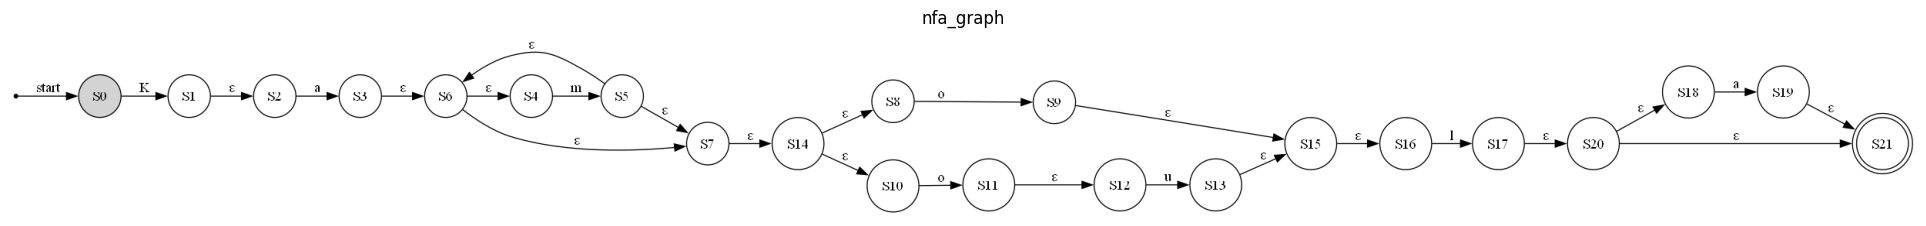

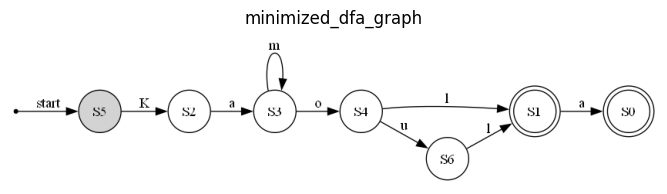

In [86]:
regex="Kam*(o|ou)la?"
main(regex)